# Example nD: Lorenz '96 (minimal weather model)

### Load basic modules.

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.interpolate import splev, splrep

### Add the (custom) source code file in the path.

In [2]:
module_path = os.path.abspath(os.path.join('../../src/'))

if module_path not in sys.path:
    sys.path.append(module_path)
# _end_if_

### Load custom modules.

In [3]:
from var_bayes.free_energy import FreeEnergy
from dynamical_systems.lorenz_96 import Lorenz96
from numerical.symbolics import get_local_polynomials

### Create a dynamic system object with fixed random seed.

In [4]:
# System dimensions.
D = 40

# Drift parameter vector.
theta = 8.0

# Diffusion noise parameters vector.
sigma = 40.0 * np.ones(D)

# Create a Lorenz96 object.
L96 = Lorenz96(sigma, theta, D, r_seed=575)

### Setup trajectory and observations settings.

In [5]:
# Time-window of inference T = [t0, tf] with step = dt.
t0, tf, dt = 0.0, 5.0, 0.001

# Make a trajectory (discrete sample path).
L96.make_trajectory(t0, tf, dt)

# Observation density.
nobs_per_time_unit = 4

# Here we can define sparse observation (in space dimensions)!
# We "observe" every other dimension (50% of the true states).
h_mask = [True if np.mod(i, 2)==0 else False for i in range(D)]

# Collect the (noise free) observations.
obs_idk, obs_val = L96.collect_obs(nobs_per_time_unit, h_mask)

# Number of observations.
num_M, dim_o = obs_val.shape

# Observation noise (variance).
obs_noise = 2.0 * np.ones(dim_o)

# Add Gaussian I.I.D. noise to the observations.
obs_val += np.sqrt(obs_noise) * L96.rng.standard_normal((num_M, dim_o))

### Plot the "true" trajectory.

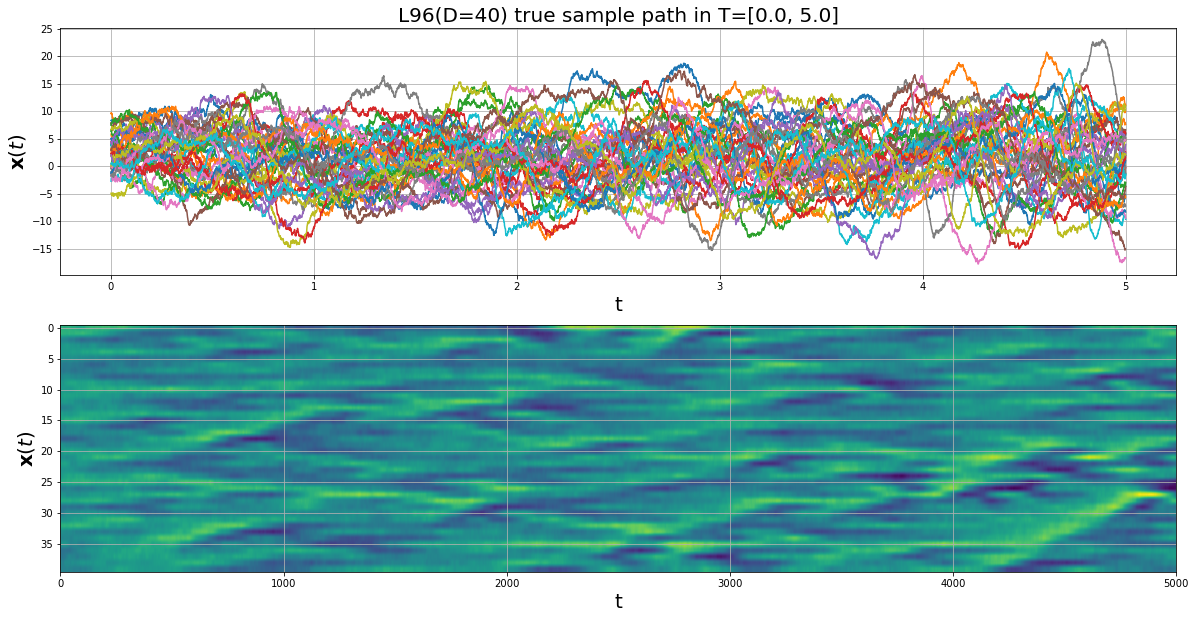

In [6]:
# Create two subplots.
_, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))

ax1.plot(L96.tk, L96.xt)

# Plot the x/y labels.
ax1.set_xlabel('t', fontsize=20)
ax1.set_ylabel("$\mathbf{x}(t)$", fontsize=20)

# Set the title.
ax1.set_title(f"L96(D={D}) true sample path in T=[{t0}, {tf}]", fontsize=20)
ax1.grid(True)

# Plot all the dimensions as an image.
ax2.imshow(L96.sample_path.T, aspect="auto")

# Plot the x/y labels.
ax2.set_xlabel('t', fontsize=20)
ax2.set_ylabel("$\mathbf{x}(t)$", fontsize=20)
ax2.grid(True)

### Create the initial path $\bf{x}_0$ to start the optimization.

If it happens to have observations at the initial and final times (i.e. t0, tf), then we do not need to extend the following vectors "spl_timex" and "spl_value".

**Note:** If we have partially observed states (using the h_mask) we can't use splines on the unobserved dimensions. In these cases we use a "smoothed" version

of the "true" path to initialize the vectors.


In [7]:
# Build the spline with these parameters.
spl_timex = np.array([t0,
                      *(obs_idk*dt),
                      tf])

spl_value = np.array([obs_val[0],
                      *obs_val,
                      obs_val[-1]])
# Initialize list.
x0 = []

# Index for the observations vector.
j = 0

# Create the initial sample path (t=0) using
# cubic B-splines at the noisy observations.
for i in range(D):
    
    # If we have an observation at the i-th
    # dimension we use it to interpolate cubic splines.
    if h_mask[i]:
        
        B_spline_cubic = splrep(spl_timex, spl_value[:, j], k=3)
        
        yy = splev(L96.tk, B_spline_cubic)
        
        j += 1
    else:
        
        # If not, we use a smoother.
        yy = savgol_filter(L96.sample_path[:, i], 51, 3) 
    # _end_if_
    
    # Append the initialization for dimension 'i'.
    x0.append(yy)
    
# _end_for_

# Convert to numpy array.
x0 = np.array(x0)

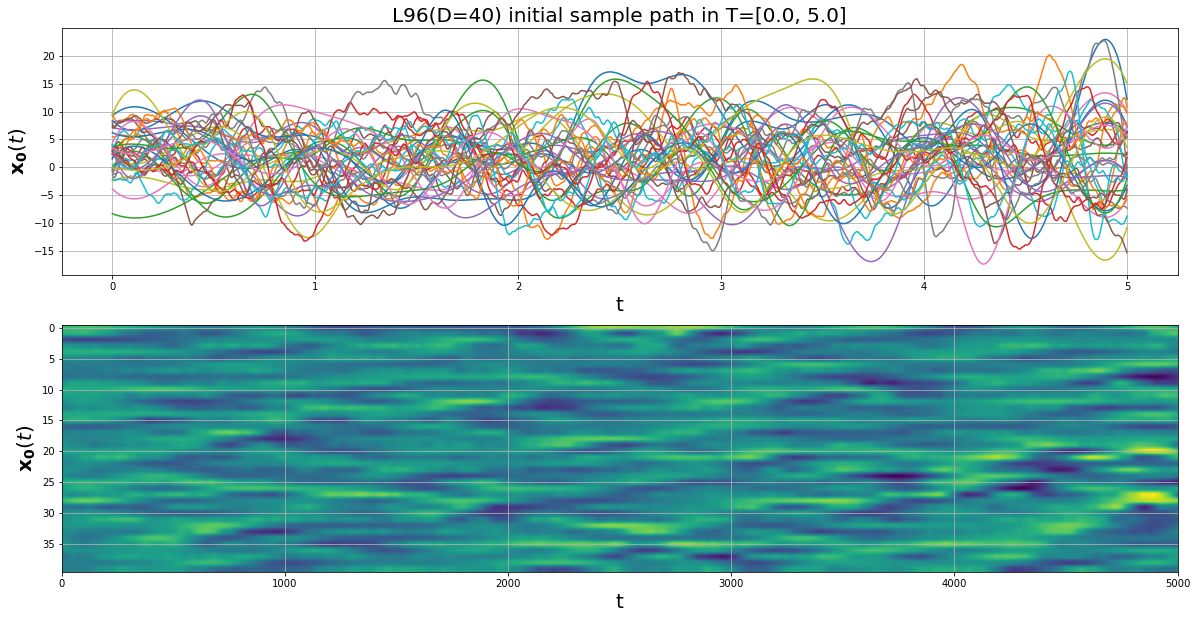

In [8]:
# Create two subplots.
_, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))

ax1.plot(L96.tk, x0.T)

# Plot the x/y labels.
ax1.set_xlabel('t', fontsize=20)
ax1.set_ylabel("$\mathbf{x_0}(t)$", fontsize=20)

# Set the title.
ax1.set_title(f"L96(D={D}) initial sample path in T=[{t0}, {tf}]", fontsize=20)
ax1.grid(True)

# Plot all the dimensions as an image.
ax2.imshow(x0, aspect="auto")

# Plot the x/y labels.
ax2.set_xlabel('t', fontsize=20)
ax2.set_ylabel("$\mathbf{x_0}(t)$", fontsize=20)
ax2.grid(True)

### Create the time indexes at the observation times.

In [9]:
# This time space is in index-units.
time_space = [0, *obs_idk, len(x0[0])-1]

mp_idk = []
sp_idk = []

for n, tn in enumerate(time_space):
    
    # Avoids out of bounds.
    if tn == time_space[-1]:
        break
    # _end_if_
    
    # Take every 4 instances.
    mp_idk.extend(np.linspace(time_space[n], time_space[n+1],
                              num=4, endpoint=True, dtype=int))
    
    # Take every 3 instances.
    sp_idk.extend(np.linspace(time_space[n], time_space[n+1],
                              num=3, endpoint=True, dtype=int))
# _end_for_

# Remove the duplicates (at observation points).
mp_idk = np.unique(mp_idk)
sp_idk = np.unique(sp_idk)

### Extract the initial mean and variance points for the optimization.

In [10]:
# Initial mean points.
mp_t0 = x0[:, mp_idk]

# Initialize variance points.
sp_t0 = 4.0 * np.ones((D, len(sp_idk)))

# Perturb with some positive noise.
sp_t0 += 2.0 * np.random.rand(*sp_t0.shape)

# Put the variance in log-space.
sp_t0 = np.log(sp_t0)

### Initial setup for the FreeEnergy object.

In [11]:
# Initial prior moments for N(mu0, tau0).
mu0 = 10.0 * np.ones(D)
tau0 = 4.0 * np.ones(D)

# Create a FreeEnergy object.
free_energy = FreeEnergy(L96, mu0, tau0, obs_idk*dt, obs_val, obs_noise, h_mask, n_jobs=6)

## Free energy minimization.

The _gradients-check_ can be very time consuming for high dimensional systems, but it is good to run it

at **least once** to make sure that the analytic gradients that we have computed match the numerical ones.

In [12]:
# Run the optimization.
opt_res = free_energy.find_minimum(np.concatenate((mp_t0.flatten(order='C'),
                                                   sp_t0.flatten(order='C')), axis=0),
                                   maxiter=500, check_gradients=False, verbose=True)

SCG: Optimization started ...
It=     0: F(x)= 3.638E+03 -:- Sum(Gradients)= 2.870E+03 -:- Delta(Elapsed)= 4.90 sec.
It=    50: F(x)= 1.682E+03 -:- Sum(Gradients)= 3.097E+00 -:- Delta(Elapsed)= 347.57 sec.
It=   100: F(x)= 1.682E+03 -:- Sum(Gradients)= 8.615E-01 -:- Delta(Elapsed)= 336.15 sec.
It=   150: F(x)= 1.682E+03 -:- Sum(Gradients)= 6.027E-01 -:- Delta(Elapsed)= 351.55 sec.
It=   200: F(x)= 1.682E+03 -:- Sum(Gradients)= 2.183E-01 -:- Delta(Elapsed)= 338.17 sec.
It=   250: F(x)= 1.682E+03 -:- Sum(Gradients)= 2.282E-01 -:- Delta(Elapsed)= 350.87 sec.
It=   300: F(x)= 1.682E+03 -:- Sum(Gradients)= 1.140E-01 -:- Delta(Elapsed)= 350.28 sec.
It=   350: F(x)= 1.682E+03 -:- Sum(Gradients)= 1.486E-01 -:- Delta(Elapsed)= 337.50 sec.
It=   400: F(x)= 1.682E+03 -:- Sum(Gradients)= 7.273E-02 -:- Delta(Elapsed)= 334.65 sec.
It=   450: F(x)= 1.682E+03 -:- Sum(Gradients)= 7.323E-02 -:- Delta(Elapsed)= 352.83 sec.
SGC: Maximum number of iterations (500) has been reached.
Elapsed time [500]: 3468

In [13]:
# Unpack the optimization results.
opt_x, opt_fx, opt_stats = opt_res

# Get the mean points.
mp_tf = opt_x[0:mp_t0.size]

# Get the variance points. Remember that they
# are in log-space so here we have to use exp().
sp_tf = np.exp(opt_x[mp_t0.size:])

# Reshape the mean/var parameters.
mp_tf = np.reshape(mp_tf, (D, (3*num_M + 4)))
sp_tf = np.reshape(sp_tf, (D, (2*num_M + 3)))

## Plots:

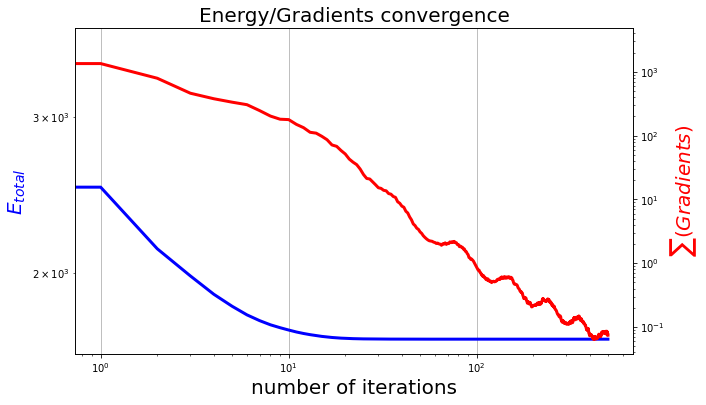

In [14]:
# Make a single plot.
_, ax1 = plt.subplots(1, figsize=(10, 6))

# Plot the energy values.
ax1.loglog(opt_stats["fx"][0:opt_stats["nit"]], color='b', linewidth=3)
ax1.set_title("Energy/Gradients convergence", fontsize=20)
ax1.set_xlabel("number of iterations", fontsize=20)
ax1.set_ylabel("$E_{total}$", color='b', fontsize=20)

# Define second y-axis that shares x-axis with current plot.
ax2 = ax1.twinx()
ax2.loglog(opt_stats["dfx"][0:opt_stats["nit"]], color='r', linewidth=3)
ax2.set_ylabel("$\sum (Gradients) $", color='r', fontsize=20)

# Plot the grid.
ax1.grid(True)

### Create the m(t) and s(t)

**Note**: since the results are in the form of Lagrange polynomials, there is no _time discretization_.

So, we can generate as many point as we want between two subsequent observation times.

In [15]:
# Get the lambda functions of the polynomials.
poly_mean, poly_vars = get_local_polynomials()

In [16]:
# Empty lists for the output functions.
tt, mt, st = [], [], []

# This time space is in time-units.
Tx = [t0, *(dt*obs_idk), tf]

# Reconstruct the mean and variance functions.
for n in range(0, len(Tx)-1):
    
    # Take the limits of the time interval.
    ti, tj = Tx[n], Tx[n+1]
    
    # It should be the same for equally spaced oservations.
    delta_t = np.abs(tj-ti)
    
    # Spacing variables fot the polynomials.
    h = float(delta_t/3.0)
    c = float(delta_t/2.0)
    
    # Extract variables for efficiency.
    nth_mean_points = mp_tf[:, (3 * n): (3 * n) + 4]
    nth_vars_points = sp_tf[:, (2 * n): (2 * n) + 3]
    
    # Since the functions are continous we can generate
    # as many m(t) and s(t) as we want. Here we collect
    # num points.
    for t in np.linspace(ti, tj, num=100, endpoint=False):

        mt_ = []
        st_ = []
        
        for i in range(D):
            
            # Prepare the parameters of the Lagrange polynomials.
            par_m = [ti, ti + h, ti + (2 * h), ti + (3 * h), *nth_mean_points[i]]
            par_s = [ti, ti + c, ti + (2 * c), *nth_vars_points[i]]
    
            mt_.append(poly_mean(t, *par_m))
            st_.append(poly_vars(t, *par_s))
        # _end_for_
        
        mt.append(mt_)
        st.append(st_)
        tt.append(t)
    # _end_for_
    
# _end_for_

mt_ = []
st_ = []

# Add the final point 'tf'.
for i in range(D):
    
    # Prepare the parameters of the Lagrange polynomials.
    par_m = [ti, ti + h, ti + (2 * h), ti + (3 * h), *nth_mean_points[i]]
    par_s = [ti, ti + c, ti + (2 * c), *nth_vars_points[i]]

    mt_.append(poly_mean(tf, *par_m))
    st_.append(poly_vars(tf, *par_s))
# _end_for_

mt.append(mt_)
st.append(st_)
tt.append(tf)

In [17]:
# Convert everything to numpy arrays.
tt = np.array(tt)
mt = np.array(mt).T
st = np.array(st).T

### Make a plot of the first 4 dimensions.

**Note** Dimensions 2 and 4 have no observations!

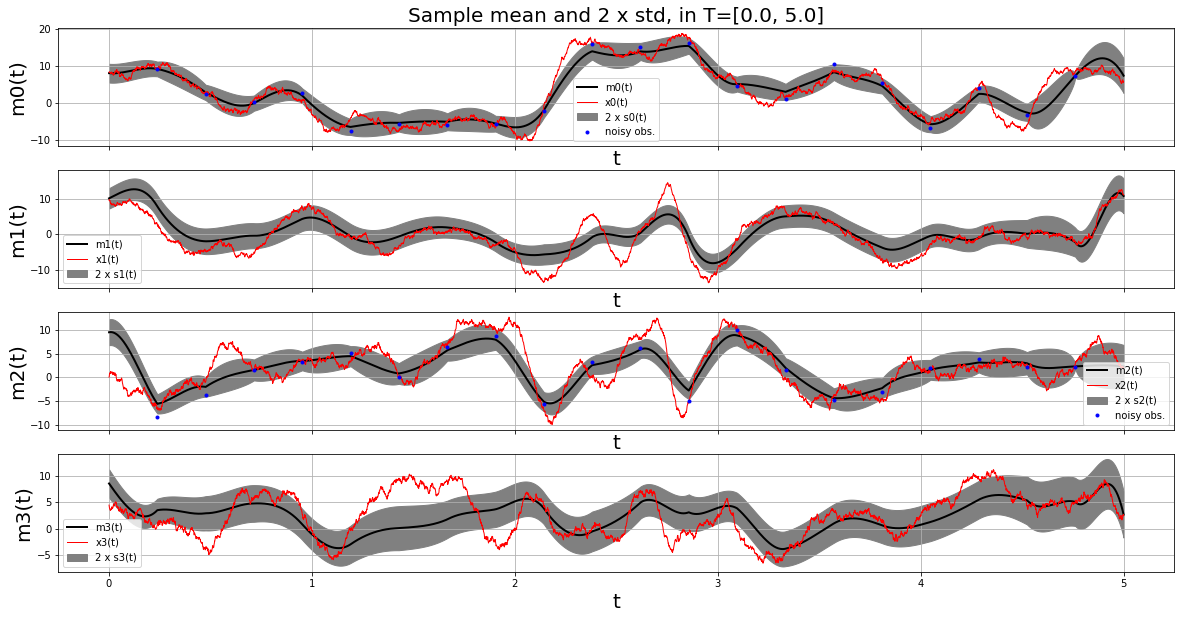

In [18]:
# Create four subplots and unpack the output array.
_, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(20, 10))

# Plot the first four dimensions.
for i, ax_i in enumerate([ax1, ax2, ax3, ax4]):
    
    # Plot the sample mean.
    ax_i.plot(tt, mt[i], 'k-', label=f"m{i}(t)", linewidth=2)
    
    # Plot the real sample path.
    ax_i.plot(L96.tk, L96.xt[:, i], 'r', label=f"x{i}(t)", linewidth=1)
    
    # Plot the 2 x std (filled envelope).
    ax_i.fill_between(tt,
                      mt[i] - 2.0*np.sqrt(st[i]),
                      mt[i] + 2.0*np.sqrt(st[i]),
                      label=f"2 x s{i}(t)", color="gray")

    # Noisy observations (if they are available).
    if h_mask[i]:
        ax_i.plot(obs_idk*dt, obs_val[:, i//2], 'bo', markersize=3, label="noisy obs.")
    # _end_if_
    
    # Plot the x/y labels.
    ax_i.set_xlabel('t', fontsize=20)
    ax_i.set_ylabel(f"m{i}(t)", fontsize=20)
    
    # Set the title only to the first plot.
    if i == 0:
        ax_i.set_title(f"Sample mean and 2 x std, in T=[{t0}, {tf}]", fontsize=20)
    # _end_if_
    
    # Plot the grid.
    ax_i.grid(True)
    
    # Set the legend.
    ax_i.legend(loc= "best")
    
# _end_for

## End of notebook